  # FEE PYX

Cython version of FEE class

In [2]:
from __future__ import print_function

In [3]:
import matplotlib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import Core.system_of_units as units
import Core.mplFunctions as mpl
import Core.wfmFunctions as wfm
import Core.tblFunctions as tbl
import Sierpe.FEE as FE
from scipy import signal
from Core.coreFunctions import wait
from Database import loadDB

In [5]:
import ICython.Core.system_of_units as SU

In [6]:
%load_ext Cython

In [7]:
import time

### Last revisited on:

In [8]:
print(time.strftime("%d/%m/%Y"))
print(time.strftime("%H:%M:%S"))

24/11/2016
15:26:57


In [38]:
%%cython

cdef class Simple:
    cdef double fee
    cdef double x[10]
    def __init__(self):
        self.fee = 10

cdef class Test:
    cdef Simple smp
    def __init__(self):
        self.smp = Simple()
    

In [53]:
%%cython
"""
Classes and functions describing the electronics of the
PMT plane FEE.
(full model)
VH, JJGC, November, 2016
"""
import numpy as np
cimport numpy as np
from scipy import signal
import Database.loadDB as DB
cimport ICython.Core.system_of_units as SU


cdef class FEEGlobals:
    cdef readonly double PMT_GAIN, x_slope, x_flat, FEE_GAIN, DAQ_GAIN, LSB, NOISE_I
    cdef readonly NOISE_DAQ, C2, C1, R1, Zin, t_sample, time_step, f_sample, f_mc 
    cdef readonly f_LPF1, f_LPF2, ADC_TO_PES_LPF, ADC_TO_PES 
    cdef readonly int NBITS, OFFSET, CEILING 
    
    def __init__(self):
        units = SU.SystemOfUnits()

        self.PMT_GAIN = 1.7e6
        self.x_slope=5.*units.ns
        self.x_flat=1.*units.ns
        self.FEE_GAIN = 582.237*units.ohm
        self.DAQ_GAIN = 1.25
        self.NBITS = 12
        self.LSB = 2.0*units.V/2**self.NBITS/self.DAQ_GAIN
        self.NOISE_I = self.LSB/(self.FEE_GAIN*self.DAQ_GAIN)
        self.NOISE_DAQ = 0.313*units.mV

        self.C2 = 8*units.nF
        self.C1 = 2714*units.nF
        self.R1 = 1567*units.ohm
        self.Zin = 62*units.ohm
        self.t_sample = 25*units.ns
        self.f_sample = 1./self.t_sample
        self.time_step = 1.*units.ns
        self.f_mc = 1./self.time_step
        self.f_LPF1 = 3*units.MHZ
        self.f_LPF2 = 10*units.MHZ
        self.ADC_TO_PES_LPF = 24.1  # After LPF, comes out from spe area
        self.ADC_TO_PES = 23.1
        self.OFFSET = 2500  # offset adc
        self.CEILING = 4096  # ceiling of adc

    cpdef double i_to_adc(self):
        """
        current to adc counts
        """
        return self.FEE_GAIN/self.LSB


    cpdef double i_to_v(self):
        """
        current to voltage
        """
        return self.FEE_GAIN


    cpdef double v_to_adc(self):
        """
        voltage to adc
        """
        return 1./self.LSB

    
cdef class SPE:
    """
    Represents a single photo-electron in the PMT
    """
    
    cdef FEEGlobals fee
    cdef SU.SystemOfUnits units
    cdef double A
    
    def __init__(self):
        self.fee = FEEGlobals()
        self.units = SU.SystemOfUnits()
                
    
    cpdef np.ndarray[np.float64_t, ndim=1] spe(self):
        """
        single photoelectron pulse
        """
        
        cdef double spe_base = self.fee.x_slope + self.fee.x_flat
        self.A = self.fee.PMT_GAIN*self.units.eplus/spe_base
        cdef int nns = int(self.fee.x_slope/self.fee.time_step)
        cdef int nnf = int(self.fee.x_flat/self.fee.time_step)
 
        cdef np.ndarray[np.float64_t, ndim=1] rise = np.linspace(0, self.A, num=nns)
        cdef np.ndarray[np.float64_t, ndim=1] fall = np.linspace(self.A, 0, num=nns)
        cdef np.ndarray[np.float64_t, ndim=1] flat = self.A*np.ones(nnf)
        
        return np.concatenate((rise, flat, fall))
    
    cpdef np.ndarray[np.float64_t, ndim=1] spe_pulse(self, float t0, float tmax, float time_step):
        """
    
        Returns a SPE pulse at time t0
        with baseline extending in steps of time_step from 0 to tmax
        determined by DELTA_L
        """
        cdef int n = int(t0/time_step)
        cdef int nmax = int(tmax/time_step)

        cdef  np.ndarray[np.float64_t, ndim=1] DELTA = np.zeros(nmax)   # Dirac delta of size DELTA_L
        DELTA[n] = 1
    
        cdef  np.ndarray[np.float64_t, ndim=1] spe_pulse = signal.convolve(DELTA, self.spe())

        return spe_pulse
    
    cpdef np.ndarray[np.float64_t, ndim=1] spe_pulse_train(self,
                                                           signal_start,
                                                           signal_length, 
                                                           daq_window,
                                                           time_step):
        """
        Returns a train of SPE pulses between signal_start
        and start+length in daq_window separated by tstep
        """
        cdef int nmin = int(signal_start/time_step)
        cdef int nmax = int((signal_start + signal_length)/time_step)
        cdef int NMAX = int(daq_window/time_step)
    
        cdef  np.ndarray[np.float64_t, ndim=1] DELTA = np.zeros(NMAX)
        DELTA[nmin:nmax+1] = 1.
    
        cdef np.ndarray[np.float64_t, ndim=1] spe_pulse = signal.convolve(DELTA, self.spe())

        return spe_pulse
    
    cpdef np.ndarray[np.float64_t, ndim=1] spe_pulse_from_ivector(self, np.ndarray[np.int64_t, ndim=1] cnt):
        """
        Returns a train of SPE pulses corresponding to vector cnt
        """

        return signal.convolve(cnt[0:-len(self.spe())+1], self.spe())
    
    cpdef np.ndarray[np.float64_t, ndim=1] spe_pulse_from_fvector(self, np.ndarray[np.float64_t, ndim=1] cnt):
        """
        Returns a train of SPE pulses corresponding to vector cnt
        """

        return signal.convolve(cnt[0:-len(self.spe())+1], self.spe())


cdef class FEE:
    """
    Complete model of Front-end electronics.
    """
    cdef double noise_FEEPMB_rms, noise_DAQ_rms
    cdef FEEGlobals fee
    cdef double coeff_blr_pmt[12] 
    cdef double coeff_c_pmt[12] 
    cdef double freq_LHPFd_pmt[12]
    cdef double C1_pmt[12] 
    cdef double R1_pmt[12]
    cdef double A1_pmt[12] 
    cdef double A2_pmt[12]
    cdef double Cr_pmt[12]
    cdef double ZC_pmt[12]
    
    
    def __init__(self, coeff_blr_pmt, coeff_c_pmt, noise_FEEPMB_rms, noise_DAQ_rms):
        self.fee = FEEGlobals()
        self.units = SU.SystemOfUnits()
        self.coeff_blr_pmt = coeff_blr_pmt
        self.coeff_c_pmt = coeff_c_pmt
        self.noise_FEEPMB_rms = noise_FEEPMB_rms
        self.noise_DAQ_rms = noise_DAQ_rms
        
        self.A1 = self.fee.R1 * self.fee.Zin/(self.fee.R1 + self.fee.Zin)  # ohms
        self.A2 = self.fee.FEE_GAIN/self.self.A1  # ohms/ohms = []
        self.R =  self.fee.R1 + self.fee.Zin
        self.Cr = 1. + self.fee.C1/self.fee.C2
        self.C =  self.fee.C1/self.self.Cr
        self.ZC = self.fee.Zin/self.self.Cr

        self.freq_LHPF = 1./(self.R * self.C)
        self.freq_LPF1 = self.fee.f_LPF1 * 2 * np.pi
        self.freq_LPF2 = self.fee.f_LPF2 * 2 * np.pi

        self.freq_LHPFd = self.freq_LHPF/(self.fee.f_sample * np.pi)
        self.freq_LPF1d = self.freq_LPF1/(self.fee.f_sample * np.pi)
        self.freq_LPF2d = self.freq_LPF2/(self.fee.f_sample  *np.pi)
        
        self.coeff_blr = self.freq_LHPFd * np.pi
        self.freq_zero = 1./(self.R1 * self.C1)
        self.coeff_c = self.freq_zero/(self.fee.f_sample * np.pi)
        
        cdef int i
        for i in range(12):
            self.freq_LHPFd_pmt[i] = self.coeff_blr_pmt[i]/np.pi
            self.C1_pmt[i] = (self.coeff_blr_pmt[i]/self.coeff_c_pmt[i])*(self.fee.C2/np.pi)
            self.R1_pmt[i] = 1./(self.coeff_c_pmt[i]*self.C1_pmt[i]*self.fee.f_sample*np.pi)
            self.A1_pmt[i] = self.R1_pmt[i] * self.fee.Zin/(self.R1_pmt[i] + self.fee.Zin)  # ohms
            self.A2_pmt[i] = self.fee.FEE_GAIN/self.A1_pmt[i]  # ohms/ohms = []
            self.Cr_pmt[i] = 1. + self.C1_pmt[i]/self.fee.C2
            self.ZC_pmt[i] = self.fee.Zin/self.Cr_pmt[i]
        
    
    cpdef np.ndarray[np.float64_t, ndim=1] noise_adc(self, np.ndarray[np.float64_t, ndim=1] signal_in_adc):
        """
        Equivalent Noise of the DAQ added at the output
        of the system
        input: a signal (in units of adc counts)
        output: a signal with DAQ noise added
        """
        
        cdef double noise_daq = self.fee.NOISE_DAQ * self.fee.v_to_adc()
        return signal_in_adc + np.random.normal(0,
                                                noise_daq,
                                                len(signal_in_adc))
    
    cpdef filter_sfee_lpf(self):
        """
        output: buttersworth parameters of the equivalent LPF 
        """
        # LPF order 1
        cdef np.ndarray[np.float64_t, ndim=1] a1, b1, a2, b2, b_aux, b
        
        b1, a1 = signal.butter(1, self.freq_LPF1d, 'low', analog=False)
        # LPF order 4
        b2, a2 = signal.butter(4, self.freq_LPF2d, 'low', analog=False)
        # convolve LPF1, LPF2
        a = np.convolve(a1, a2, mode='full')
        b_aux = np.convolve(b1, b2, mode='full')
        b = self.fee.FEE_GAIN*b_aux
        return b, a
    
    cpdef filter_fee(self, int ipmt):
        """
           ipmt = pmt number
           output: buttersworth parameters of the equivalent FEE filter
        """

    
        cdef double coef = self.freq_LHPFd_pmt[ipmt]
        cdef double A1 = self.A1_pmt[ipmt]
        cdef double A2 = self.A2_pmt[ipmt]
        cdef double ZC = self.ZC_pmt[ipmt]
    
        if ipmt == -1:
            coef = self.freq_LHPFd
            A1 = self.A1
            A2 = self.A2
            ZC = self.ZC
    
        cdef np.ndarray[np.float64_t, ndim=1] a1, b1, a2, b2, a0, b0, b11, a11, b21, a21 
        cdef np.ndarray[np.float64_t, ndim=1] a_aux, b_aux, b_aux2, a, b
    
        b1, a1 = signal.butter(1, coef, 'high', analog=False)
        b2, a2 = signal.butter(1, coef, 'low', analog=False)

        b0 = b2*ZC + b1*A1  # in ohms
        a0 = a1

        # LPF order 1
        b1l, a1l = signal.butter(1,
                                 self.freq_LPF1d, 'low',
                                 analog=False)
        # LPF order 4
        b2l, a2l = signal.butter(4,
                                 self.freq_LPF2d, 'low',
                                 analog=False)
        # convolve HPF, LPF1
        a_aux = np.convolve(a0, a1l, mode='full')
        b_aux = np.convolve(b0, b1l, mode='full')
    
        # convolve HPF+LPF1, LPF2
        a = np.convolve(a_aux, a2l, mode='full')
        b_aux2 = np.convolve(b_aux, b2l, mode='full')
        b = A2*b_aux2  # in ohms

        return b, a
   
    cpdef filter_cleaner(self, int ipmt):
        """
        cleans the input signal
        """
        cdef double coef = self.coeff_c_pmt[ipmt]
        if ipmt == -1:
            coef = self.coeff_c
        
        cdef np.ndarray[np.float64_t, ndim=1] a, b
    
        b, a = signal.butter(1, coef, 'high', analog=False)

        return b, a
    
    cpdef np.ndarray[np.float64_t, ndim=1] signal_v_fee(self, 
                                                        np.ndarray[np.float64_t, ndim=1] signal_i, 
                                                        int ipmt):
        """
        input: signal_i = signal current (i = A)
           pmt number
        output: signal_v (in volts) with effect FEE

        ++++++++++++++++++++++++++++++++++++++++++++++++
        +++++++++++ PMT+FEE NOISE ADDED HERE +++++++++++
        ++++++++++++++++++++++++++++++++++++++++++++++++

        """
        
        cdef np.ndarray[np.float64_t, ndim=1] noise_FEEin = np.zeros(len(signal_i))
        if self.noise_FEEPMB_rms > 0:
            noise_FEEin = np.random.normal(0,
                                           self.noise_FEEPMB_rms,
                                           len(signal_i))

        # Equivalent Noise of the FEE + PMT BASE added at the input
        # of the system to get the noise filtering effect
        cdef np.ndarray[np.float64_t, ndim=1] a, b

        b, a = self.filter_fee(ipmt)  # b in ohms
        # filtered signal in I*R = V
        return signal.lfilter(b, a, signal_i + noise_FEEin)
    
    
    cpdef np.ndarray[np.float64_t, ndim=1] signal_clean(self, 
                                                        np.ndarray[np.float64_t, ndim=1] signal_fee, 
                                                        int ipmt):
        """
        input: signal_fee = adc, convoluted
           instance of class FEE
        output: signal_c cleaning filter passed

        """
        cdef np.ndarray[np.float64_t, ndim=1] a, b
        b, a = self.filter_cleaner(ipmt)
        return signal.lfilter(b, a, signal_fee)
    
    cpdef np.ndarray[np.float64_t, ndim=1] daq_decimator(self,
                                                         float f_sample1, 
                                                         float f_sample2, 
                                                         np.ndarray[np.float64_t, ndim=1] signal_in):
        """
        downscales the signal vector according to the
        scale defined by f_sample1 (1 GHZ) and
        f_sample2 (40 Mhz).
        Includes anti-aliasing filter
        """

        cdef int scale = int(f_sample1/f_sample2)
        return signal.decimate(signal_in, scale, ftype='fir')



In [18]:
feg = FEEGlobals()
units = SU.SystemOfUnits()

In [19]:
cspe = SPE()

In [20]:
spe = FE.SPE()

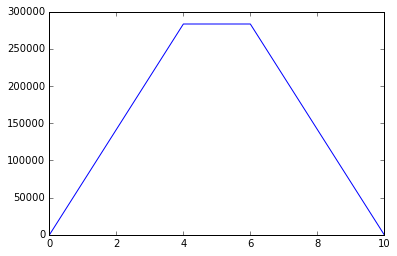

In [21]:
plt.plot(spe.spe)

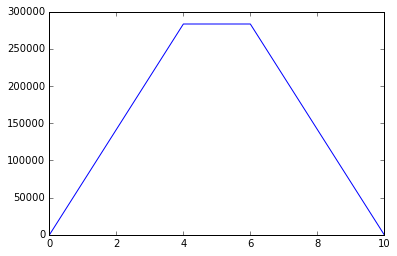

In [22]:
plt.plot(cspe.spe())

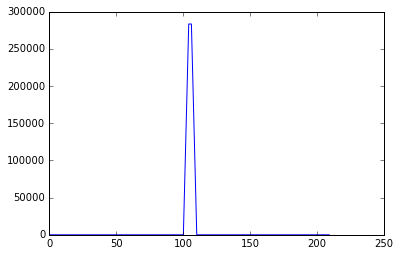

In [23]:
plt.plot(FE.spe_pulse(spe,t0=100*units.ns, tmax=200*units.ns,
              time_step=1*units.ns))

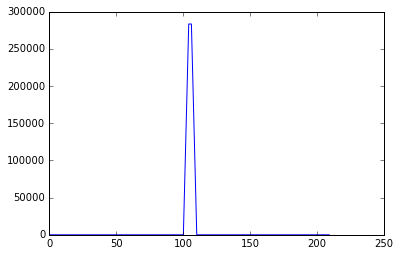

In [24]:
plt.plot(cspe.spe_pulse(t0=100*units.ns, tmax=200*units.ns,
              time_step=1*units.ns))

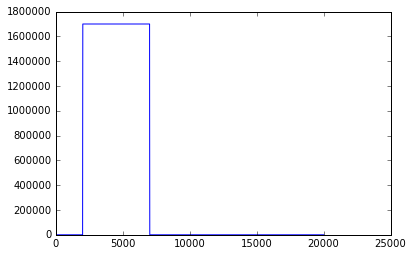

In [25]:
plt.plot(FE.spe_pulse_train(spe,
                    signal_start=2000*units.ns,
                    signal_length=5000*units.ns, daq_window=20*units.mus,
                    time_step=1*units.ns))

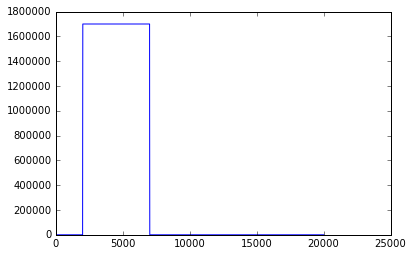

In [26]:
plt.plot(cspe.spe_pulse_train(signal_start=2000*units.ns,
                    signal_length=5000*units.ns, daq_window=20*units.mus,
                    time_step=1*units.ns))

In [27]:
cnt = np.random.poisson(5, 10000)

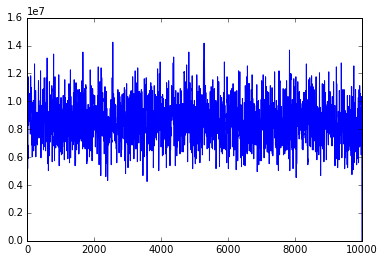

In [28]:
plt.plot(FE.spe_pulse_from_vector(spe, cnt))

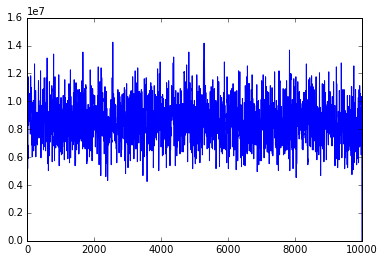

In [29]:
plt.plot(cspe.spe_pulse_from_ivector(cnt))